Make sure you fill your name and NetID below:

In [ ]:
NAME = "Sammy Berger"

---

# DQN for Mountain Car testing

In [ ]:
### Setup:

import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

#this is mostly for pylSER
from keras import models
from keras import layers
from keras.optimizers import Adam
from collections import deque

#should switch pylSER to GPU
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 2 , 'CPU': 1} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

#both this stuff and the things above it are for gkhayes
!pip install 'gym[box2d]'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
!apt-get install ffmpeg -y

# hopefully fix crash during rendering
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

     |████████████████████████████████| 450kB 8.6MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (425 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 

## Using pylSER's algorithm:

This is currently non-functional. Some updates to Python and its libraries since 2017 have rendered the implementation in its current state unusable.

Original code: https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car

In [ ]:
class MountainCarTrain:
    def __init__(self,env):
        self.env=env
        self.gamma=0.99

        self.epsilon = 1
        self.epsilon_decay = 0.05

        self.epsilon_min=0.01


        self.learingRate=0.001

        self.replayBuffer=deque(maxlen=20000)
        self.trainNetwork=self.createNetwork()

        self.episodeNum=400

        self.iterationNum=201 #max is 200

        self.numPickFromBuffer=32

        self.targetNetwork=self.createNetwork()

        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

    def createNetwork(self):
        model = models.Sequential()
        state_shape = self.env.observation_space.shape

        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        # model.compile(optimizer=optimizers.RMSprop(lr=self.learingRate), loss=losses.mean_squared_error)
        model.compile(loss='mse', optimizer=Adam(lr=self.learingRate))
        return model

    def getBestAction(self,state):

        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3)
        else:
            action=np.argmax(self.trainNetwork.predict(state)[0])

        return action

    

    def trainFromBuffer_Boost(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return
        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)
        npsamples = np.array(samples)
        states_temp, actions_temp, rewards_temp, newstates_temp, dones_temp = np.hsplit(npsamples, 5)
        states = np.concatenate((np.squeeze(states_temp[:])), axis = 0)
        rewards = rewards_temp.reshape(self.numPickFromBuffer,).astype(float)
        targets = self.trainNetwork.predict(states)
        newstates = np.concatenate(np.concatenate(newstates_temp))
        dones = np.concatenate(dones_temp).astype(bool)
        notdones = ~dones
        notdones = notdones.astype(float)
        dones = dones.astype(float)
        Q_futures = self.targetNetwork.predict(newstates).max(axis = 1)
        targets[(np.arange(self.numPickFromBuffer), actions_temp.reshape(self.numPickFromBuffer,).astype(int))] = rewards * dones + (rewards + Q_futures * self.gamma)*notdones
        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)



    def trainFromBuffer(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return

        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.numPickFromBuffer, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.numPickFromBuffer, 2)

        targets = self.trainNetwork.predict(states)
        new_state_targets=self.targetNetwork.predict(newStates)

        i=0
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            i+=1

        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)


    def orginalTry(self,currentState,eps):
        rewardSum = 0
        max_position=-99

        for i in range(self.iterationNum):
            bestAction = self.getBestAction(currentState)

            #show the animation every 50 eps
            if eps%50==0:
                env.render()

            new_state, reward, done, _ = env.step(bestAction)

            new_state = new_state.reshape(1, 2)

            # # Keep track of max position
            if new_state[0][0] > max_position:
                max_position = new_state[0][0]


            # # Adjust reward for task completion
            if new_state[0][0] >= 0.5:
                reward += 10

            self.replayBuffer.append([currentState, bestAction, reward, new_state, done])

            #Or you can use self.trainFromBuffer_Boost(), it is a matrix wise version for boosting 
            #self.trainFromBuffer()
            self.trainFromBuffer_Boost()

            rewardSum += reward

            currentState = new_state

            if done:
                break

        if i >= 199:
            print("Failed to finish task in epsoide {}".format(eps))
        else:
            print("Success in epsoide {}, used {} iterations!".format(eps, i))
            self.trainNetwork.save('./trainNetworkInEPS{}.h5'.format(eps))

        #Sync
        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

        print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon_min, self.epsilon), rewardSum,max_position))
        self.epsilon -= self.epsilon_decay

    def start(self):
        for eps in range(self.episodeNum):
            currentState=env.reset().reshape(1,2)
            self.orginalTry(currentState, eps)


#device = torch.device('cuda:0')
env = gym.make('MountainCar-v0')
dqn=MountainCarTrain(env=env)
dqn.start()

NameError: ignored

## Using gkhayes's algorithm:

This is the current best functioning DQN that attempts to learn Mountain Car that we have. It doesn't work that well, and reward never breaches about -150 over a short training period.

This might be due to DQNs being particularly bad at learning to solve Mountain Car as proposed, or due to updates to Python/the packages used since this code was written. Credit goes to https://gist.github.com/gkhayes/3d154e0505e31d6367be22ed3da2e955/

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -198.2
Episode 400 Average Reward: -199.57
Episode 500 Average Reward: -196.17
Episode 600 Average Reward: -190.4
Episode 700 Average Reward: -186.37
Episode 800 Average Reward: -190.22
Episode 900 Average Reward: -189.18
Episode 1000 Average Reward: -190.11
Episode 1100 Average Reward: -154.8
Episode 1200 Average Reward: -159.21
Episode 1300 Average Reward: -177.81
Episode 1400 Average Reward: -179.23
Episode 1500 Average Reward: -155.31
Episode 1600 Average Reward: -157.5
Episode 1700 Average Reward: -178.49
Episode 1800 Average Reward: -173.46
Episode 1900 Average Reward: -165.74
Episode 2000 Average Reward: -183.78
Episode 2100 Average Reward: -164.95
Episode 2200 Average Reward: -175.78
Episode 2300 Average Reward: -176.07
Episode 2400 Average Reward: -168.99
Episode 2500 Average Reward: -160.72
Episode 2600 Average Reward: -162.34
Episode 2700 Average Reward: -156.9
Episode 2800 Aver

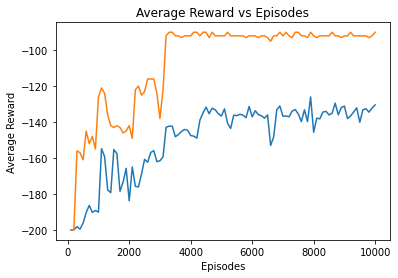

In [ ]:
# Import and initialize Mountain Car Environment
env = gym.make('MountainCar-v0')
env.reset()

# Define Q-learning function
def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    max_reward_list = []
    
    # Calculate episodic reduction in epsilon

    
    # reduction = (epsilon - min_eps)/episodes
    reduction = (epsilon - min_eps)/100
    
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
    
        while done != True:   
            # Render environment for last five episodes
            if i >= (episodes - 20):
                env.render()
                
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:

            max_reward = np.max(reward_list)
            max_reward_list.append(max_reward)

            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)

            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
    env.close()
    
    return ave_reward_list, max_reward_list

# Run Q-learning algorithm
avgs, maxs = QLearning(env, 0.2, 0.9, 0.8, 0, 10000)

# Plot Rewards
plt.plot(100*(np.arange(len(avgs)) + 1), avgs, label="average rewards")
plt.plot(100*(np.arange(len(maxs)) + 1), maxs, label="max rewards")
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

plt.show()
#!gupload --to '1_F2AELuEcgPA3dV0gBJt746fiDkWBPmZ' plt.gcf()

#plt.savefig('rewards.jpg')     
plt.close()  